In [3]:
import pandas as pd
import numpy as np

# Load the dataset
df_bcn = pd.read_csv("datasets/Final_cleaned_dataset/bcn_final_cleaned_data_csv.csv", delimiter = ';')
df_mad = pd.read_csv("Datasets/Final_cleaned_dataset/mad_final_cleaned_date.csv", delimiter = ';')

# Calculate log-transformed price
df_bcn['log_price'] = np.log(df_bcn['price'])
df_mad['log_price'] = np.log(df_mad['price'])

In [4]:
from sklearn.preprocessing import StandardScaler

# Normalize the log-transformed prices
scaler = StandardScaler()

df_bcn['log_price_normalized'] = scaler.fit_transform(df_bcn[['log_price']])
df_mad['log_price_normalized'] = scaler.fit_transform(df_mad[['log_price']])

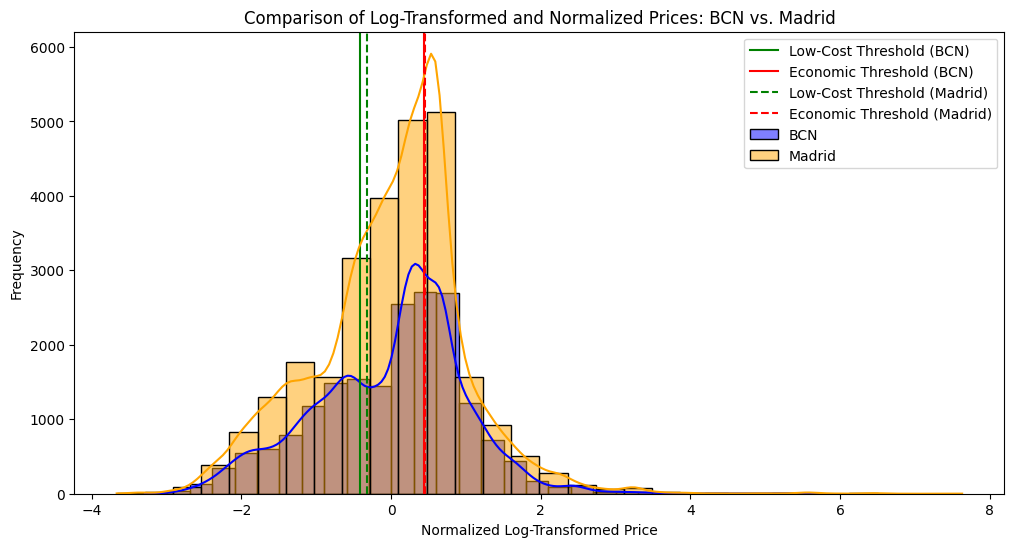

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for BCN
sns.histplot(df_bcn['log_price_normalized'], bins=30, kde=True, color='blue', label='BCN')
plt.axvline(x=df_bcn['log_price_normalized'].quantile(0.33), color='green', label='Low-Cost Threshold (BCN)')
plt.axvline(x=df_bcn['log_price_normalized'].quantile(0.66), color='red', label='Economic Threshold (BCN)')

# Plot for Madrid
sns.histplot(df_mad['log_price_normalized'], bins=30, kde=True, color='orange', label='Madrid', alpha=0.5)
plt.axvline(x=df_mad['log_price_normalized'].quantile(0.33), color='green', linestyle='dashed', label='Low-Cost Threshold (Madrid)')
plt.axvline(x=df_mad['log_price_normalized'].quantile(0.66), color='red', linestyle='dashed', label='Economic Threshold (Madrid)')

plt.title('Comparison of Log-Transformed and Normalized Prices: BCN vs. Madrid')
plt.xlabel('Normalized Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* Due to the different sample sizes between the two datasets (Madrid has significantly more data points than Barcelona), which affects the visual comparison on the histogram. To address this, we have normalized the histograms so that the area under each curve is the same, regardless of the number of data points in each dataset. 

### Adjusting the Histogram for Different Sample Sizes

Set the stat parameter in sns.histplot to 'density', which normalizes the histogram, making the total area under the curve equal to 1 for each dataset.

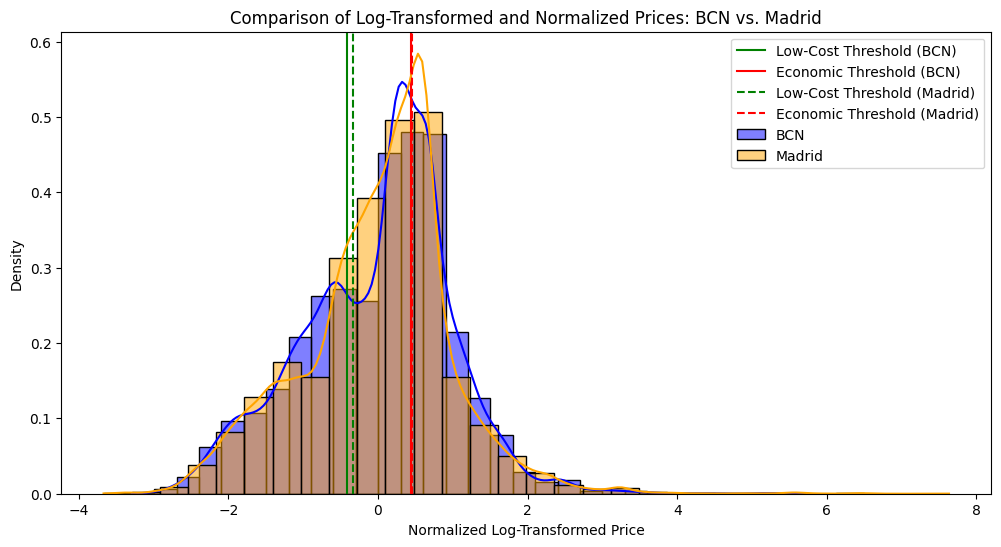

In [6]:
plt.figure(figsize=(12, 6))

# Plot for BCN
sns.histplot(df_bcn['log_price_normalized'], bins=30, kde=True, color='blue', label='BCN', stat='density')
plt.axvline(x=df_bcn['log_price_normalized'].quantile(0.33), color='green', label='Low-Cost Threshold (BCN)')
plt.axvline(x=df_bcn['log_price_normalized'].quantile(0.66), color='red', label='Economic Threshold (BCN)')

# Plot for Madrid
sns.histplot(df_mad['log_price_normalized'], bins=30, kde=True, color='orange', label='Madrid', alpha=0.5, stat='density')
plt.axvline(x=df_mad['log_price_normalized'].quantile(0.33), color='green', linestyle='dashed', label='Low-Cost Threshold (Madrid)')
plt.axvline(x=df_mad['log_price_normalized'].quantile(0.66), color='red', linestyle='dashed', label='Economic Threshold (Madrid)')

plt.title('Comparison of Log-Transformed and Normalized Prices: BCN vs. Madrid')
plt.xlabel('Normalized Log-Transformed Price')
plt.ylabel('Density')
plt.legend()
plt.show()


### Calculate New Thresholds Using K-Means Clustering

This method divides the log-transformed, normalized prices into three clusters, representing Low-Cost, Economic, and Luxury segments. The cluster centers (thresholds) are then used to assign categories.


In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'log_price_normalized' is already calculated

# K-means clustering to determine price segments (3 clusters: Low-Cost, Economic, Luxury)
kmeans_bcn = KMeans(n_clusters=3, random_state=0).fit(df_bcn[['log_price_normalized']])
kmeans_mad = KMeans(n_clusters=3, random_state=0).fit(df_mad[['log_price_normalized']])

# Assign clusters to the data
df_bcn['price_segment'] = kmeans_bcn.labels_
df_mad['price_segment'] = kmeans_mad.labels_

# Sort the cluster centers to determine the thresholds
bcn_thresholds = np.sort(kmeans_bcn.cluster_centers_.flatten())
mad_thresholds = np.sort(kmeans_mad.cluster_centers_.flatten())

print("Barcelona Thresholds (log):", bcn_thresholds)
print("Madrid Thresholds (log):", mad_thresholds)


Barcelona Thresholds (log): [-1.39680017 -0.00753601  1.02803408]
Madrid Thresholds (log): [-1.29165547  0.22321583  1.54923301]


### Use pd.cut function:

This function is used to create the categories based on the thresholds. -np.inf and np.inf are used to ensure that all prices, no matter how extreme, are included in the categories.

In [14]:
# Define categories based on the thresholds for Barcelona
df_bcn['price_category'] = pd.cut(df_bcn['log_price_normalized'],
                                  bins=[-np.inf, bcn_thresholds[0], bcn_thresholds[1], np.inf],
                                  labels=['Low-Cost', 'Economic', 'Luxury'])

# Define categories based on the thresholds for Madrid
df_mad['price_category'] = pd.cut(df_mad['log_price_normalized'],
                                  bins=[-np.inf, mad_thresholds[0], mad_thresholds[1], np.inf],
                                  labels=['Low-Cost', 'Economic', 'Luxury'])

# Check the distribution of the new price categories
print(df_bcn['price_category'].value_counts())
print(df_mad['price_category'].value_counts())


price_category
Luxury      10889
Economic     6097
Low-Cost     1871
Name: count, dtype: int64
price_category
Luxury      12408
Economic    11261
Low-Cost     3199
Name: count, dtype: int64


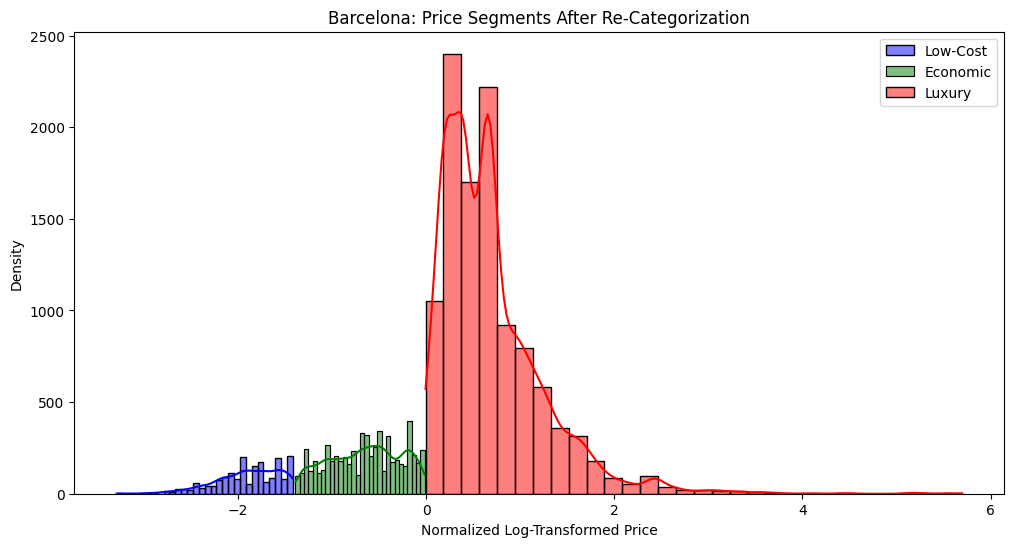

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot each category separately
sns.histplot(data=df_bcn[df_bcn['price_category'] == 'Low-Cost'], x='log_price_normalized', bins=30, kde=True, color='blue', label='Low-Cost')
sns.histplot(data=df_bcn[df_bcn['price_category'] == 'Economic'], x='log_price_normalized', bins=30, kde=True, color='green', label='Economic')
sns.histplot(data=df_bcn[df_bcn['price_category'] == 'Luxury'], x='log_price_normalized', bins=30, kde=True, color='red', label='Luxury')

# Add a title and labels
plt.title('Barcelona: Price Segments After Re-Categorization')
plt.xlabel('Normalized Log-Transformed Price')
plt.ylabel('Density')
plt.legend()
plt.show()


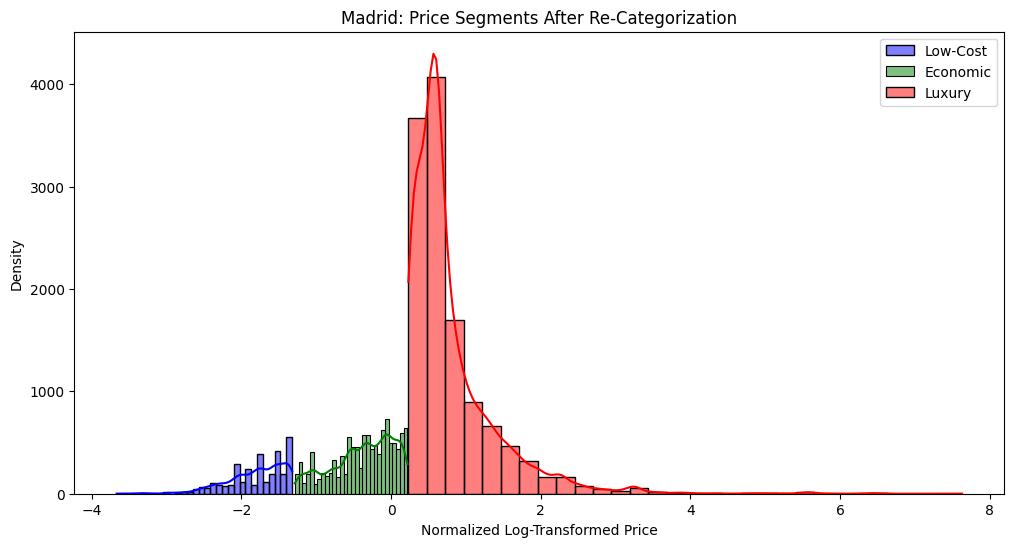

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot each category separately for Madrid
sns.histplot(data=df_mad[df_mad['price_category'] == 'Low-Cost'], x='log_price_normalized', bins=30, kde=True, color='blue', label='Low-Cost')
sns.histplot(data=df_mad[df_mad['price_category'] == 'Economic'], x='log_price_normalized', bins=30, kde=True, color='green', label='Economic')
sns.histplot(data=df_mad[df_mad['price_category'] == 'Luxury'], x='log_price_normalized', bins=30, kde=True, color='red', label='Luxury')

# Add a title and labels
plt.title('Madrid: Price Segments After Re-Categorization')
plt.xlabel('Normalized Log-Transformed Price')
plt.ylabel('Density')
plt.legend()
plt.show()


#### Compare raw price betwen two cities after removing outliers

In [17]:
import numpy as np

# Calculate Q1 (25th percentile) and Q3 (75th percentile) and IQR for Barcelona
Q1_bcn = df_bcn['price'].quantile(0.25)
Q3_bcn = df_bcn['price'].quantile(0.75)
IQR_bcn = Q3_bcn - Q1_bcn

# Calculate the lower and upper bound to identify outliers
lower_bound_bcn = Q1_bcn - 1.5 * IQR_bcn
upper_bound_bcn = Q3_bcn + 1.5 * IQR_bcn

# Filter out the outliers in Barcelona
df_bcn_cleaned = df_bcn[(df_bcn['price'] >= lower_bound_bcn) & (df_bcn['price'] <= upper_bound_bcn)]

# Repeat the same process for Madrid
Q1_mad = df_mad['price'].quantile(0.25)
Q3_mad = df_mad['price'].quantile(0.75)
IQR_mad = Q3_mad - Q1_mad

lower_bound_mad = Q1_mad - 1.5 * IQR_mad
upper_bound_mad = Q3_mad + 1.5 * IQR_mad

df_mad_cleaned = df_mad[(df_mad['price'] >= lower_bound_mad) & (df_mad['price'] <= upper_bound_mad)]


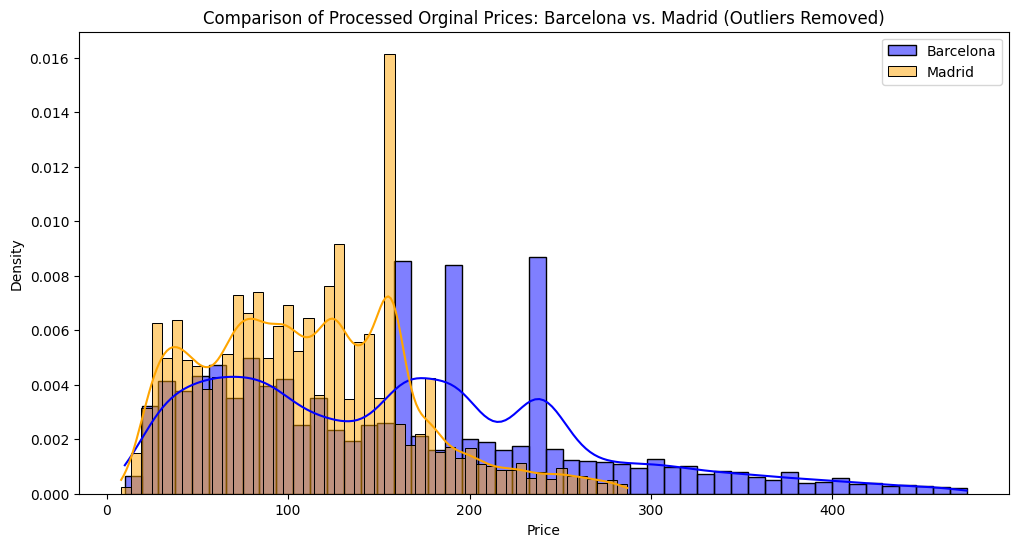

In [19]:
## Plot the processed price distribution

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the cleaned prices for Barcelona
sns.histplot(df_bcn_cleaned['price'], bins=50, kde=True, color='blue', label='Barcelona', stat='density')

# Plot the cleaned prices for Madrid
sns.histplot(df_mad_cleaned['price'], bins=50, kde=True, color='orange', label='Madrid', stat='density', alpha=0.5)

# Add a title and labels
plt.title('Comparison of Processed Orginal Prices: Barcelona vs. Madrid (Outliers Removed)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()
